In [1]:
%pylab inline
import matplotlib.pyplot as plt
from astropy.convolution import convolve_fft
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D

Populating the interactive namespace from numpy and matplotlib


Below is some code to do the rebinning

In [2]:
def rebin(array, dimensions=None, scale=None):
    """ Return the array ``array`` to the new ``dimensions`` conserving flux the flux in the bins
    The sum of the array will remain the same
 
    >>> ar = numpy.array([
        [0,1,2],
        [1,2,3],
        [2,3,4]
        ])
    >>> rebin(ar, (2,2))
    array([
        [1.5, 4.5]
        [4.5, 7.5]
        ])
    Raises
    ------
 
    AssertionError
        If the totals of the input and result array don't agree, raise an error because computation may have gone wrong
 
    Reference
    =========
    +-+-+-+
    |1|2|3|
    +-+-+-+
    |4|5|6|
    +-+-+-+
    |7|8|9|
    +-+-+-+
    """
    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    print (dimensions)
    print ("Rebinning to Dimensions: %s, %s" % tuple(dimensions))
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = numpy.zeros(dimensions)
    for j, i in itertools.product(*map(range, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result

In [3]:
# Create a Gaussian source
gauss1 = Gaussian2D(100, 500.0, 500.0, 5, 5)
kernel = Gaussian2D(1, 100.0, 100.0, 25, 25)

In [4]:
x = np.arange(0,1001)
y = np.arange(0,1001)
x, y = np.meshgrid(x, y)
data_2D = gauss1(x, y) 
x1 = np.arange(0,201)
y1 = np.arange(0,201)
x1, y1 = np.meshgrid(x1, y1)
kernel_2D = kernel(x1, y1) 

The plots below represent the ground truth on an ideal grid, the real size of a source and a PSF. I will assume that the PSF has a resolution of 20% with respect to the "ideal" grid, while the data has a resolution of 8% with respect to the same grid. We will later convolve the data with the PSF.

Text(0,0.5,'y [pixels]')

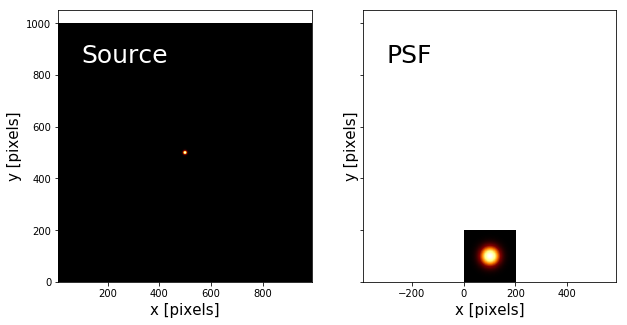

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,5))
cmap = 'afmhot'
ax1.imshow(data_2D, interpolation='None',origin='lower',cmap=cmap)
ax1.text(100,850,'Source',color='w',size=25)
ax1.axis('tight')
ax1.axes.set_aspect('equal')
ax1.set_xlabel('x [pixels]',size=15)
ax1.set_ylabel('y [pixels]',size=15)
ax2.imshow(kernel_2D, interpolation='None',origin='lower',cmap=cmap)
ax2.text(-300,850,'PSF',color='black',size=25)
ax2.axis('tight')
ax2.axes.set_aspect('equal')
ax2.set_xlabel('x [pixels]',size=15)
ax2.set_ylabel('y [pixels]',size=15)
#plt.colorbar()

In [6]:
# Here we bin the data at the different resolutions.
data_binned = rebin(data_2D,(201,201))
kernel_binned = rebin(kernel_2D,(51,51))
kernel_binned1 = rebin(kernel_2D,(21,21))

(201, 201)
Rebinning to Dimensions: 201, 201
(51, 51)
Rebinning to Dimensions: 51, 51
(21, 21)
Rebinning to Dimensions: 21, 21


The plots below represent the source at the PSF resolution (left), the PSF at its own resolution (center) and the PSF at the data resolution (right). Typically we will pass to Sherpa both the source model (left) and the PSF at the PSF resolution. The problem is that before we do the rebinning of the PSF, we will be passing the PSF to the right. Since Sherpa cannot tell the pixel sizes, it will assume that the pixels are of the same size and will therefore produce a convolved source that is *smaller* than it should be.


Text(0,0.5,'y [pixels]')

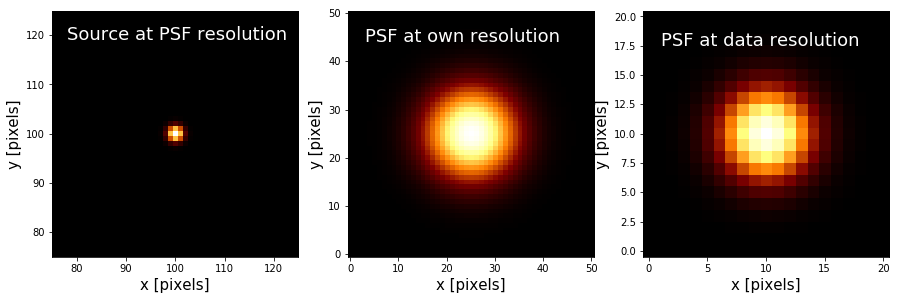

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
cmap = 'afmhot'
ax1.imshow(data_binned, interpolation='None',origin='lower',cmap=cmap)
ax1.text(78,119,'Source at PSF resolution',color='w',size=18)
ax1.set_xlim(75,125)
ax1.set_ylim(75,125)
ax1.set_xlabel('x [pixels]',size=15)
ax1.set_ylabel('y [pixels]',size=15)
ax2.imshow(kernel_binned, interpolation='None',origin='lower',cmap=cmap)
ax2.text(3,44,'PSF at own resolution',color='w',size=18)
ax2.set_xlabel('x [pixels]',size=15)
ax2.set_ylabel('y [pixels]',size=15)
ax3.imshow(kernel_binned1, interpolation='None',origin='lower',cmap=cmap)
ax3.text(1,17.5,'PSF at data resolution',color='w',size=18)
ax3.set_xlabel('x [pixels]',size=15)
ax3.set_ylabel('y [pixels]',size=15)

We now perform the convolution with both the correct PSF resolution (kernel_binned), and with the wrong resolution (kernel_binned1, data resolution). Then we show that the results of the concolution are different.

In [15]:
#Convolve
convol_data = convolve(data_binned, kernel_binned)
convol_data1 = convolve(data_binned, kernel_binned1)

Text(0,0.5,'y [pixels]')

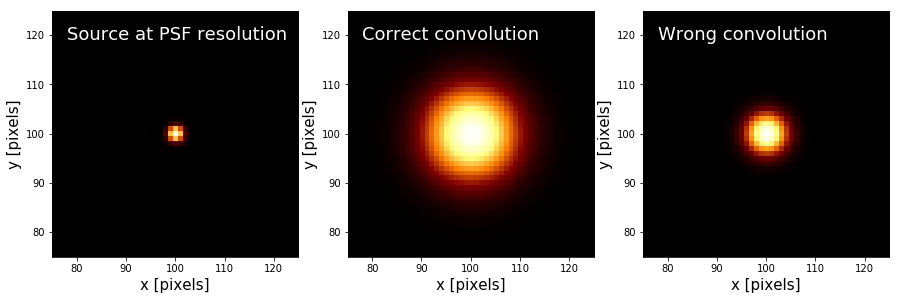

In [27]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
cmap = 'afmhot'
ax1.imshow(data_binned, interpolation='None',origin='lower',cmap=cmap)
ax1.text(78,119,'Source at PSF resolution',color='w',size=18)
ax1.set_xlim(75,125)
ax1.set_ylim(75,125)
ax1.set_xlabel('x [pixels]',size=15)
ax1.set_ylabel('y [pixels]',size=15)
ax2.imshow(convol_data, interpolation='None',origin='lower',cmap=cmap)
ax2.text(78,119,'Correct convolution',color='w',size=18)
ax2.set_xlim(75,125)
ax2.set_ylim(75,125)
ax2.set_xlabel('x [pixels]',size=15)
ax2.set_ylabel('y [pixels]',size=15)
ax3.imshow(convol_data1, interpolation='None',origin='lower',cmap=cmap)
ax3.text(78,119,'Wrong convolution',color='w',size=18)
ax3.set_xlim(75,125)
ax3.set_ylim(75,125)
ax3.set_xlabel('x [pixels]',size=15)
ax3.set_ylabel('y [pixels]',size=15)

We note that the image in the center has the right size (the with of the convolution is the same as the *real* width of the PSF), whereas the convolution to the left has a smaller (wrong) size. When we bin to the grid size of the data, we see: 

In [22]:
source_final = rebin(data_binned,(81,81))
source_convol = rebin(convol_data,(81,81))
source_convol1 = rebin(convol_data1,(81,81))

(81, 81)
Rebinning to Dimensions: 81, 81
(81, 81)
Rebinning to Dimensions: 81, 81
(81, 81)
Rebinning to Dimensions: 81, 81


Text(0,0.5,'y [pixels]')

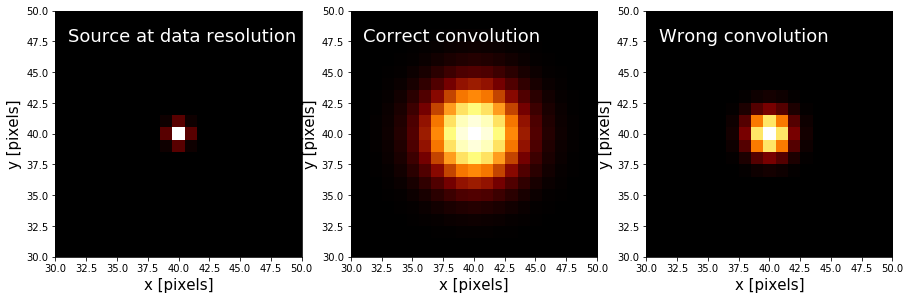

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
cmap = 'afmhot'
ax1.imshow(source_final, interpolation='None',origin='lower',cmap=cmap)
ax1.text(31,47.5,'Source at data resolution',color='w',size=18)
ax1.set_xlim(30,50)
ax1.set_ylim(30,50)
ax1.set_xlabel('x [pixels]',size=15)
ax1.set_ylabel('y [pixels]',size=15)
ax2.imshow(source_convol, interpolation='None',origin='lower',cmap=cmap)
ax2.text(31,47.5,'Correct convolution',color='w',size=18)
ax2.set_xlim(30,50)
ax2.set_ylim(30,50)
ax2.set_xlabel('x [pixels]',size=15)
ax2.set_ylabel('y [pixels]',size=15)
ax3.imshow(source_convol1, interpolation='None',origin='lower',cmap=cmap)
ax3.text(31,47.5,'Wrong convolution',color='w',size=18)
ax3.set_xlim(30,50)
ax3.set_ylim(30,50)
ax3.set_xlabel('x [pixels]',size=15)
ax3.set_ylabel('y [pixels]',size=15)

Finally, we should pay attention to the amplitude of the resulting Gaussians. See the difference in intensity between correct and wrong convolution:

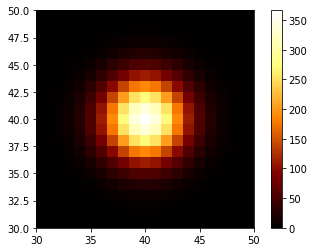

In [36]:
plt.imshow(source_convol, interpolation='None',origin='lower',cmap=cmap)
plt.xlim(30,50)
plt.ylim(30,50)
plt.colorbar()

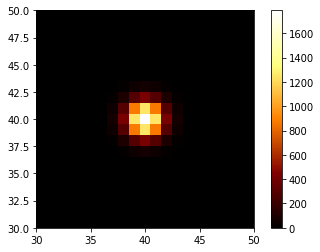

In [37]:
plt.imshow(source_convol1, interpolation='None',origin='lower',cmap=cmap)
plt.xlim(30,50)
plt.ylim(30,50)
plt.colorbar()